In [6]:
import numpy as np
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
import phate
import pandas as pd

In [23]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

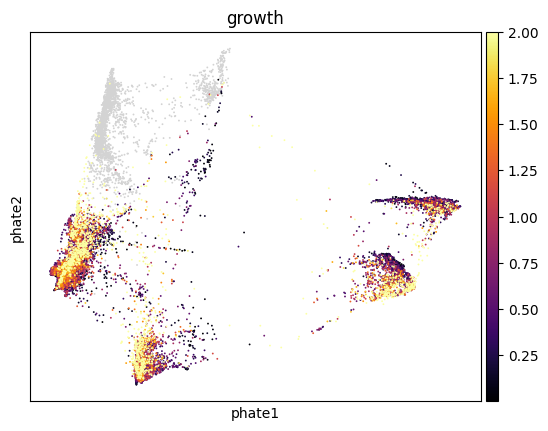

In [26]:
sc.external.pl.phate(adata, color='growth', cmap='inferno', vmax=2)

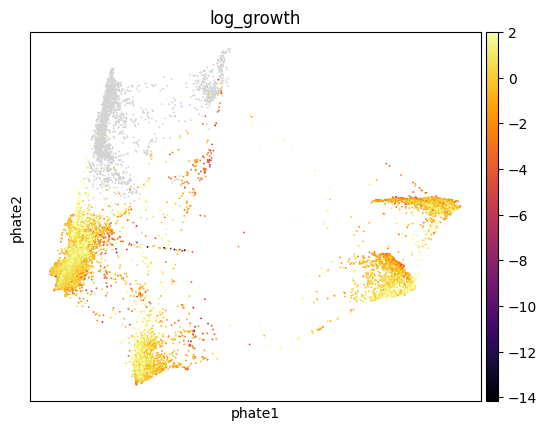

In [27]:
sc.external.pl.phate(adata, color='log_growth', cmap='inferno', vmax=2)


<Axes: >

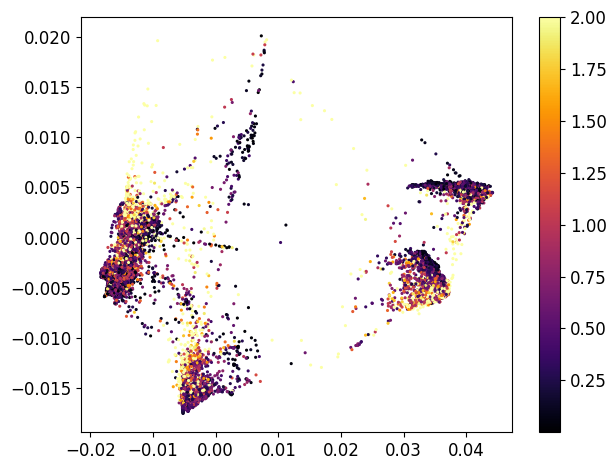

In [33]:
scprep.plot.scatter2d(adata.obsm['X_phate'], adata.obs['growth'].clip(upper=2), cmap='inferno')

In [29]:
# merging 12 and 18 because they are mostly overlapping.
time_dict = {
    0.0: 0,
    2.0: 1,
    12.0: 2,
    18.0: 3,
    30.0: 4,
}
adata.obs['time'] = adata.obs['day'].map(time_dict)

mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=['d1', 'd2'])
mioflow_df['samples'] = adata.obs['time'].values
mioflow_df['growth'] = adata.obs['growth'].values
mioflow_df.to_csv(f'../data/mioflow_data_w_growth.csv')

In [25]:
assert 'growth' not in adata.obs.columns

AssertionError: 

In [4]:
from ot.unbalanced import sinkhorn_knopp_unbalanced
from scipy.spatial.distance import cdist

def get_transform_matrix(gamma, a, epsilon=1e-8):
    return (np.diag(1.0 / (a+ epsilon)) @ gamma).T

def get_growth_coeffs(gamma, a, epsilon=1e-8, normalize=False):                                                                         
    T = get_transform_matrix(gamma, a, epsilon)                                                                                         
    unnormalized_coeffs = np.sum(T, axis=0)                                                                                             
    if not normalize:                                                                                                                   
        return unnormalized_coeffs                                                                                                      
    return unnormalized_coeffs / np.sum(unnormalized_coeffs) * len(unnormalized_coeffs)   

def calc_growth(source, target):
    alpha = 2
    a = adata.obsm['X_pca'][adata.obs['day'] == source]
    b = adata.obsm['X_pca'][adata.obs['day'] == target]
    m, n = a.shape[0], b.shape[0]
    M = cdist(a,b)
    entropy_reg = 0.1
    reg_1, reg_2 = alpha, 10000
    gamma = sinkhorn_knopp_unbalanced(np.ones(m) / m, np.ones(n) / n, M, entropy_reg, reg_1, reg_2)
    return get_growth_coeffs(gamma, np.ones(m) / m)

In [14]:
adata.obs['sample_id'].value_counts()

12    4305
18    4040
30    2971
0     2837
2     2832
Name: sample_id, dtype: int64

In [7]:
samples = [0, 2, 12, 18, 30]
dfs = []
for i in range(len(samples)):
    if i == 0:
        continue
    gc = calc_growth(samples[i - 1], samples[i])
    index = adata.obs.index[adata.obs['sample_id'] == samples[i-1]]
    df = pd.DataFrame(gc, index=index)
    dfs.append(df)
df = pd.concat(dfs)
df.columns = ['growth']
dff = pd.concat([adata.obs[adata.obs['sample_id'] != 30], df], axis=1)


In [18]:
# adata.obs.loc[dff.index, 'growth']

AAACCTGAGTTCGCGC-1-4   NaN
AAACCTGCAGGACCCT-1-4   NaN
AAACCTGCATGTTGAC-1-4   NaN
AAACCTGGTCGAACAG-1-4   NaN
AAACCTGTCCGTTGCT-1-4   NaN
                        ..
TTTGTCAGTTCGGGCT-1-7   NaN
TTTGTCAGTTTGGCGC-1-7   NaN
TTTGTCATCAGGCCCA-1-7   NaN
TTTGTCATCCGCATCT-1-7   NaN
TTTGTCATCCTTTCGG-1-7   NaN
Name: growth, Length: 14014, dtype: float64

In [22]:
# # Create temporary copy of the DataFrame and ensure unique columns
# dff_temp = dff.copy()
# dff_temp = dff_temp.loc[:,~dff_temp.columns.duplicated()]

# # Initialize columns with NaN
# adata.obs['growth'] = np.nan
# adata.obs['log_growth'] = np.nan

# # Update values using the temporary copy with unique columns
# growth_values = dff_temp['growth'].values
# adata.obs.loc[dff_temp.index, 'growth'] = growth_values
# adata.obs.loc[dff_temp.index, 'log_growth'] = np.log2(growth_values)